In [1]:
import mlrun
# get/create a project and register the data prep and trainer function in it
project = mlrun.get_or_create_project(
    name="ny-taxi-batch-demo", user_project=True, context="./"
)

> 2022-11-17 12:46:14,179 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-17 12:46:14,180 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-17 12:46:14,222 [info] loaded project ny-taxi-batch-demo from MLRun DB


In [2]:
project.set_function('src/data_prep.py', 'data-prep', image='mlrun/ml-models',
                     handler='data_preparation', kind="job")
project.set_function('src/trainer.py', 'trainer', image='mlrun/ml-models',
                     handler='train', kind="job")
project.set_function("hub://batch_inference", 'batch_predict', image='mlrun/ml-models',
                     kind="job")
project.save()

In [3]:
# execute the function through MLRun SDK (can run locally or over the k8s cluster)
data_prep = project.run_function("data-prep", inputs={"dataset": "./data/dataset.csv"}, local=True)

# get the returned data artifact
train_dataset = data_prep.artifact("train_dataset").as_df()
train_dataset.head()

> 2022-11-17 12:46:14,720 [info] starting run data-prep-data_preparation uid=45485c8b79714fa4af85e2654583b97e DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ny-taxi-batch-demo-davesh,...4583b97e,0,Nov 17 12:46:14,completed,data-prep-data_preparation,v3io_user=Daveshkind=owner=Daveshhost=jupyter-davids-55f4d7f589-bm7n5,dataset,,label_column=fare_amount,train_datasettest_dataset


> 2022-11-17 12:46:21,328 [info] run executed, status=completed


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,bearing,distance,hour,day,month,weekday,year
1574,4.6,-1.291108,0.711319,-1.290995,0.711415,1,41.886532,36.260192,17.233230,19.661998,11.424632,-0.862873,0.016481,1,30,3,0,2009
5267,7.0,-1.291589,0.710814,-1.291356,0.710861,1,41.542565,30.159901,23.488799,11.908896,3.643413,-1.370905,0.026389,21,3,12,0,2012
19662,17.0,-1.290700,0.711561,-1.290985,0.712118,1,44.521351,40.967886,15.182461,25.902143,17.901636,0.472611,0.069569,17,27,2,4,2015
5528,6.5,-1.291662,0.710880,-1.291697,0.710629,1,42.861675,28.001151,25.783369,9.814947,2.092454,3.005992,0.028146,2,19,4,6,2015
5387,6.0,-1.290977,0.711547,-1.290869,0.711429,1,41.928540,38.032769,15.716957,21.652892,13.405894,-2.405482,0.017784,12,30,12,1,2014


In [4]:
# execute the function through MLRun SDK (can run locally or over the k8s cluster)
train = project.run_function("trainer",
                             inputs={"train_set": data_prep.outputs["train_dataset"]})

# print the results of the training run
train.outputs

> 2022-11-17 12:46:21,490 [info] starting run trainer-train uid=c64c134290f146e5b2871b1166a237aa DB=http://mlrun-api:8080
> 2022-11-17 12:46:21,697 [info] Job is running in the background, pod: trainer-train-fn7k6
> 2022-11-17 12:46:32,150 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ny-taxi-batch-demo-davesh,...66a237aa,0,Nov 17 12:46:25,completed,trainer-train,v3io_user=Daveshkind=jobowner=Daveshmlrun/client_version=1.2.0-rc10host=trainer-train-fn7k6,train_set,,mean_absolute_error=1.7109088057103867r2_score=0.8445047903825152root_mean_squared_error=3.5362835351310644mean_squared_error=12.505301240839058,feature-importancetest_setmodel


> 2022-11-17 12:46:41,345 [info] run executed, status=completed


{'mean_absolute_error': 1.7109088057103867,
 'r2_score': 0.8445047903825152,
 'root_mean_squared_error': 3.5362835351310644,
 'mean_squared_error': 12.505301240839058,
 'feature-importance': 'v3io:///projects/ny-taxi-batch-demo-davesh/artifacts/trainer-train/0/feature-importance.html',
 'test_set': 'store://artifacts/ny-taxi-batch-demo-davesh/trainer-train_test_set:c64c134290f146e5b2871b1166a237aa',
 'model': 'store://artifacts/ny-taxi-batch-demo-davesh/lgbm_ny_taxi:c64c134290f146e5b2871b1166a237aa'}

In [5]:
# Register the workflow file:
workflow_name = "lgbm_ny_taxi_pipeline_batch_predict"
project.set_workflow(workflow_name, "src/workflow-batch.py")

# Save the project:
project.save()

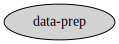

In [ ]:
workflow_run = project.run(
    name=workflow_name,
    arguments={
        "batch": "https://s3.us-east-1.wasabisys.com/iguazio/data/nyc-taxi/test.csv",
        "model": str(train.outputs["model"]),
    },
    watch=True,
)

In [ ]:
project.get_artifact('batch-inference_drift_table_plot').to_dataitem().show()
